#**Fine_tuning VinaLLaMA for Chatbot**

##1. Setup Thư viện

In [4]:
!pip install -q -U bitsandbytes
!pip install -q -U datasets
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U loralib
!pip install -q -U einops
!pip install -q -U googletrans==3.1.0a0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 944.1 kB/s eta 0:00:00
  Preparing metada

##2. Import Thư viện


In [5]:
import json
import os
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers

from googletrans import Translator
from pprint import pprint
from datasets import load_dataset
from huggingface_hub import notebook_login
from peft import (
    LoraConfig ,
    PeftConfig ,
    PeftModel ,
    get_peft_model ,
    prepare_model_for_kbit_training
)
from transformers import (
    AutoConfig ,
    AutoModelForCausalLM ,
    AutoTokenizer ,
    BitsAndBytesConfig
)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

##3. Khởi tạo mô hình


In [10]:
MODEL_NAME = "vilm/vinallama-7b-chat"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "q_proj",
        "up_proj",
        "o_proj",
        "k_proj",
        "down_proj",
        "gate_proj",
        "v_proj"
    ],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


##4. Sử dụng mô hình (Trước khi huấn luyện)

In [11]:
#Cài đặt các tham số
generation_config = model.generation_config
generation_config.max_new_token = 200
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id

In [14]:
#Khai báo prompt
prompt = """
<|im_start|>system
Bạn là một trợ lý AI hữu ích. Hãy trả lời người dùng một cách chính xác.
<|im_end|>
<|im_start|>user
Mô tả về thành phố Nam Định.
<|im_end|>
<|im_start|>assistant
""".strip()

In [15]:
#Chạy mô hình
%%time
device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoding = tokenizer(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
    outputs = model.generate(
        input_ids=encoding.input_ids,
        attention_mask=encoding.attention_mask,
        generation_config=generation_config
    )
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

<|im_start|> system
Bạn là một trợ lý AI hữu ích. Hãy trả lời người dùng một cách chính xác.
 
<|im_start|> user
Mô tả về thành phố Nam Định.
 
<|im_start|> assistant
Nam Định là một thành phố lịch sử nằm ở phía Bắc của Việt Nam, thuộc vùng đồng bằng sông Hồng. Được biết đến như thủ đô văn hóa của miền Bắc, thành phố này có dân số hơn 200.000 người và đóng vai trò là trung tâm chính trị, kinh tế và văn hóa của tỉnh Nam Định.

Thành phố Nam Định có một lịch sử phong phú với những di tích cổ đại và các địa danh lịch sử, phản ánh vai trò quan trọng của nó trong quá khứ. Một số điểm thu hút du khách bao gồm Thành trì thế kỷ XV, Đền Chúa Thác Bạc và Khu phố cổ Nam Định.

Về kinh tế, Nam Định là một trung tâm nông nghiệp và công nghiệp quan trọng, với các ngành sản xuất, chế tạo và nông nghiệp chiếm phần lớn cơ sở hạ tầng kinh tế của thành phố.Một số ngành công nghiệp chính bao gồm sản xuất đồ gia dụng, sản xuất hàng may mặc, chế biến thực phẩm và sản xuất sắt thép.

Nam Định cũng nổi tiếng 

Như vậy, có thể thấy chỉ với mô hình gốc (gọi là pre-trained model), chúng ta đã có thể
tương tác với mô hình ngôn ngữ lớn và yêu cầu thực hiện một tác vụ nào đó với độ chính
xác tương đối. Trong lĩnh vực Machine Learning, chúng ta còn có thể cải thiện kết quả của
pre-trained model với một task cụ thể nào đó bằng cách áp dụng một kỹ thuật được gọi là
fine-tuning. Cụ thể, chúng ta sẽ tiếp tục thực hiện huấn luyện mô hình, trên một bộ dữ liệu
với các task cụ thể hơn (ứng với nhu cầu và mục đich sử dụng của chúng ta).

##5. Tải bộ dữ liệu fine-tuning

In [17]:
#Xây dựng chatbot với các cuộc đối thoại thường nhật
#Dùng alespalla/chatbot_instruction_prompts
data = load_dataset('alespalla/chatbot_instruction_prompts')

Generating train split:   0%|          | 0/258042 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/64511 [00:00<?, ? examples/s]

<center>

Biến data có thông tin như sau:  
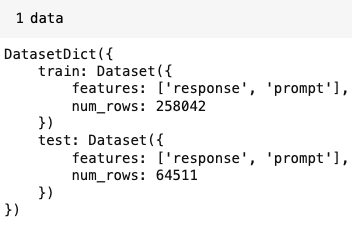

</center>

##6. Xây dựng bộ dữ liệu fine-tuning

In [18]:
#Xây dựng hàm tạo prompt

def generate_prompt(data_point):
    translator = Translator()
    vn_prompt = translator.translate(data_point['prompt'], src='en', dest='vi').text
    vn_response = translator.translate(data_point['response'], src='en', dest='vi').text

    return f"""
<|im_start|>system
Bạn là một trợ lý AI hữu ích. Hãy trả lời người dùng một cách chính xác.
<|im_end|>
<|im_start|>user
{vn_prompt}
<|im_end|>
<|im_start|>assistant
{vn_response}
""".strip()

**Xây dựng hàm tokenization**  
Đối với bất kì mô hình ngôn ngữ lớn nào, để xử lý một văn
bản nào, trước hết chúng ta cần thực hiện tokenization lên văn bản đó. Hiểu một cách đơn
giản, chúng ta sẽ đưa văn bản từ dạng string thành một list (vector) các con số:

In [19]:
#Xây dựng hàm tokenization
def generate_and_tokenize_prompt(data_point):
    full_prompt = generate_prompt(data_point)
    tokenized_full_prompt = tokenizer(full_prompt, padding=True, truncation=True)

    return tokenized_full_prompt

In [ ]:
#Áp dụng tokenization vào bộ dữ liệu
data = data['train'].shard(num_shards=50, index=0).filter(lambda sample:
    sample['response'] != '' and sample['prompt'] != '').shuffle().map(generate_and_tokenize_prompt)

Filter:   0%|          | 0/5161 [00:00<?, ? examples/s]

Map:   0%|          | 0/5161 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


##7. Thực hiện huấn luyện mô hình (fine-tuning)

In [ ]:
training_args = transformers.TrainingArguments(
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 4,
    num_train_epochs = 1,
    learning_rate = 2e-4,
    fp16 = True,
    save_total_limit = 3,
    logging_steps = 1,
    output_dir="experiments",
    optim="paged_adamw_8bit",
    lr_scheduler_type="consine",
    warmup_ratio=0.05
)

trainer = transformers.Trainer(
    model = model,
    train_dataset=data,
    args=training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

model.config.use_cache = False
trainer.train()


##8. Chạy mô hình đã fine-tuning

In [ ]:
%%time
device = 'cuda' if torch.cuda.is_available() else 'cpu'

prompt = """
<|im_start|>system
Bạn là một trợ lý AI hữu ích. Hãy trả lời người dùng một cách chính xác.
<|im_end|>
<|im_start|>user
Mô tả về thành phố Nam Định
<|im_end|>
<|im_start|>assistant
""".strip()

encoding = tokenizer(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
    outputs = model.generate(
        input_ids = encoding.input_ids,
        attention_mask=encoding.attention_mask,
        generation_config=generation_config
    )
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

#**Fine-tuning VinaLLaMA for solving elementary math**

<center>

Huấn luyện với bộ dữ liệu toán cấp 1 được thu thập tại hllj/vi_grade_school_math_mcq  
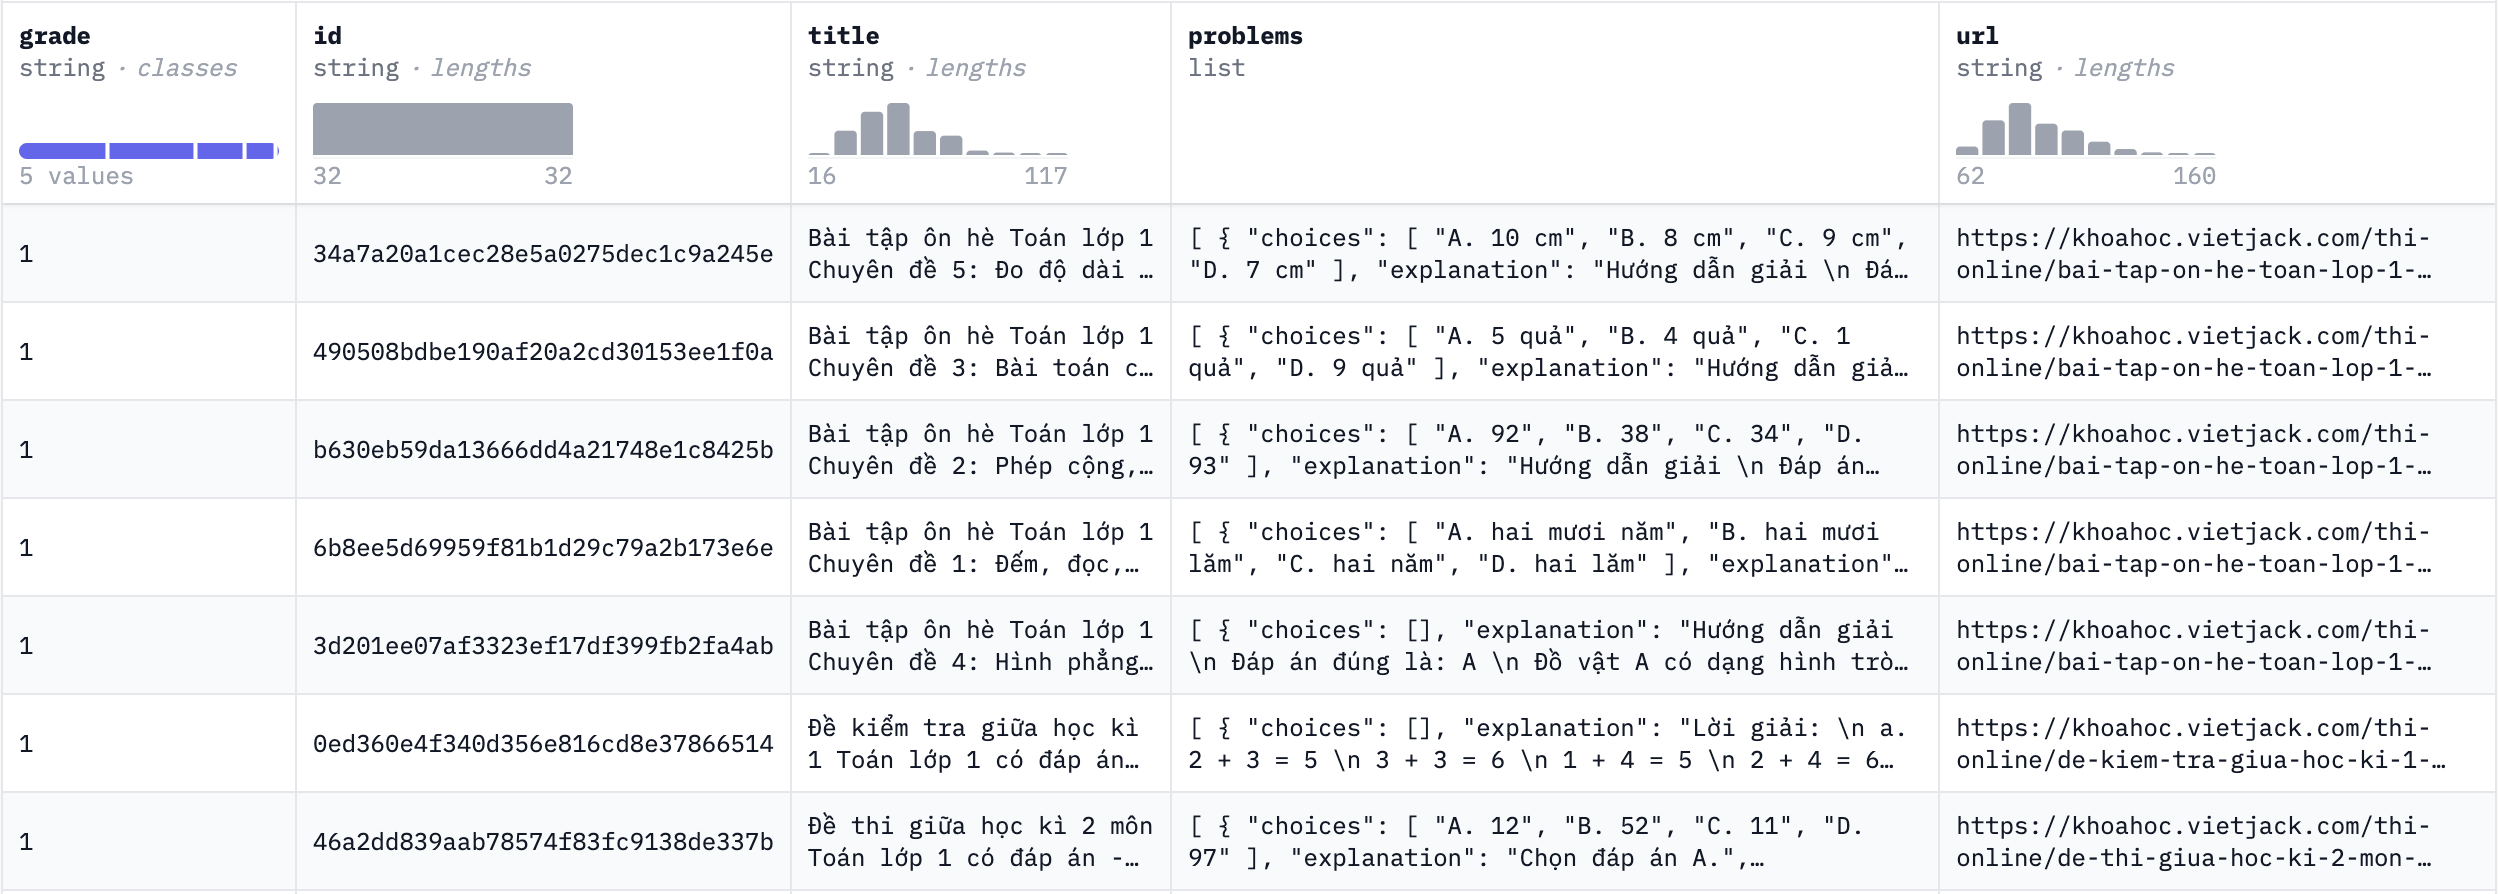

</center>

##1. Setup Thư viện

In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U datasets
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U loralib
!pip install -q -U einops

##2. Import các thư viện cần thiết

In [ ]:
import json
import os
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers

from pprint import pprint
from datasets import load_dataset
from huggingface_hub import notebook_login
from peft import (
    LoraConfig ,
    PeftConfig ,
    PeftModel ,
    get_peft_model ,
    prepare_model_for_kbit_training
)
from transformers import (
    AutoConfig ,
    AutoModelForCausalLM ,
    AutoTokenizer ,
    BitsAndBytesConfig
)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

##3. Khởi tạo mô hình

In [ ]:
MODEL_NAME = "vilm/vinallama-7b-chat"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type=="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausaLLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

model.grandent_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "q_proj",
        "up_proj",
        "o_proj",
        "k_proj",
        "down_proj",
        "gate_proj",
        "v_proj"
    ],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)

##4. Xây dựng bộ dữ liệu fine-tuning

In [ ]:
#Tải bộ dữ liệu
data = load_dataset('hllj/vi_grade_school_math_mcq')

**Xây dựng hàm tạo prompt**   
Khác với hàm phần trước, ở đây ta điều chỉnh sao cho phù hợp với ngữ cảnh bài toán.

In [ ]:
#Xây dựng hàm tạo prompt

def generate_prompt(question, choices, explanation):
    return f"""
<|im_start|>system
Bạn là một chuyên gia về toán. Bạn sẽ nhận câu hỏi trắc nghiệm kèm theo các lựa chọn, hãy giải step by step nếu có và chọn phương án đúng.

<|im_start|>user
### Câu hỏi:
{question}
### Các lựa chọn:
{choices}
### Câu trả lời:

<|im_start|>assistant
{explanation}
""".strip()

#Xây dựng hàm tokenization
def generate_and_tokenize_prompt(question, choices, explanation):
    full_prompt = generate_prompt(question, choices, explanation)
    tokenized_full_prompt = tokenizer(
        full_prompt,
        padding=True,
        truncation=True
    )

    return tokenized_full_prompt

**Áp dụng hàm xây dựng prompt vào bộ dữ liệu**  
Nhận thấy, thông tin trong trường
samples của bộ dữ liệu là một list chứa các cặp câu hỏi và câu trả lời như hình dưới đây:  

<center>

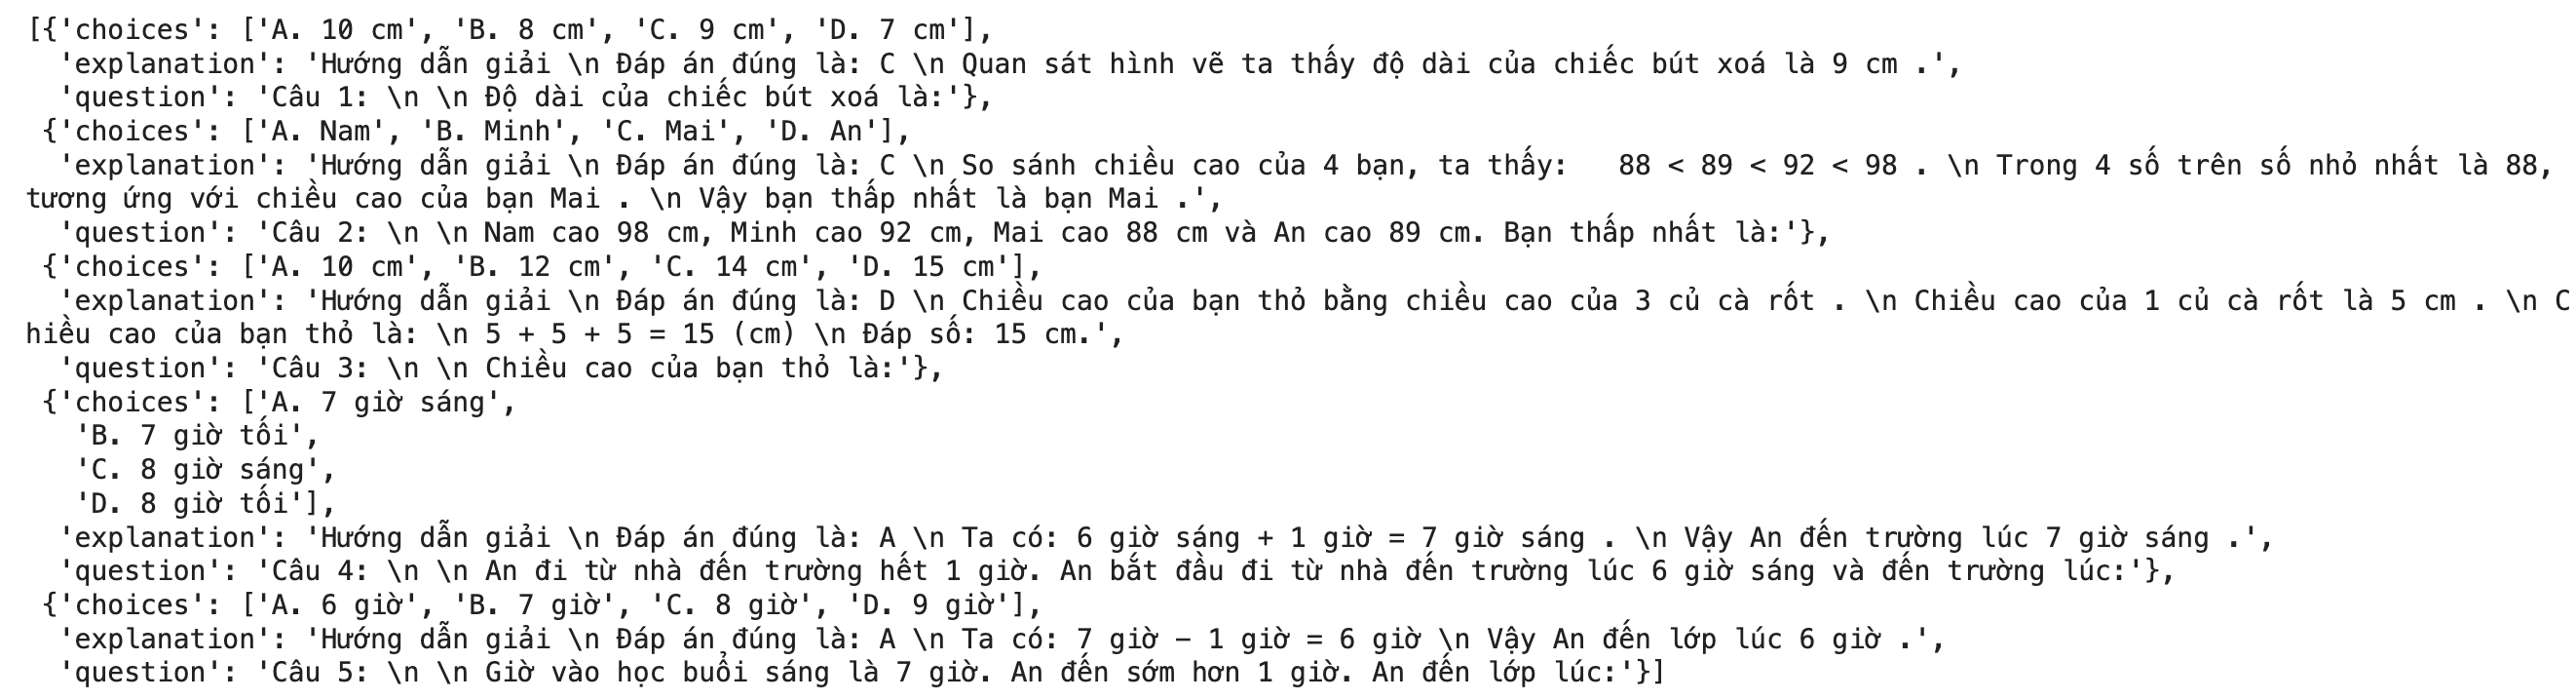

</center>  
Vì lẽ đó, ta sẽ truy cập vào trường thông tin này để bốc tách ra từng cặp câu hỏi - câu trả
lời và áp dụng hàm tạo prompt vừa triển khai để có một mẫu dữ liệu huấn luyện hoàn chỉnh:

In [ ]:
training_samples = []
for sample in tqdm(data['train']):
    for quest in sample['problems']:
        choices = quest['choices']
        explanation = quest['explanation'].strip()
        question = quest['question']

        if explanation == '' or question == '' or choices == []:
            continue

        try:
            question = question.split('\n \n')[1].strip()
        except:
            continue

        choices = '\n'.join(choices)
        training_sample = generate_and_tokenize_prompt(
            question, choices, explanation
        )

        training_samples.append(training_sample)

choices_data = Dataset.from_list(training_)

**Trong đó:**  
• **Dòng 1**: Khởi tạo một list rỗng, dùng để lưu các mẫu dữ liệu huấn luyện.  
• **Dòng 2**: Duyệt qua từng hàng trong bộ dữ liệu gốc.  
• **Dòng 3**: Trong trường thông tin ’problems’ tại hàng đang xét, duyệt qua từng câu hỏi.  
• **Từ dòng 4 đến 16**: Tách thông tin câu hỏi (question), các lựa chọn trắc nghiệm (choices) và câu trả lời (explanation).  
• **Từ dòng 17 đến 23**: Gọi hàm tạo prompt để lấy mẫu dữ liệu huấn luyện hoàn chỉnh.
Sau đó, đưa vào list rỗng khởi tạo ở dòng 1.  
Kết thúc vòng lặp, thực hiện chuyển đổi list
sang HuggingFace Dataset.

##5. Thực hiện huấn luyện  
Với bộ dữ liệu mới đã chuẩn bị, ta tiến hành fine-tuning mô hình. Lưu
ý rằng, thời gian huấn luyện theo đúng như mô tả sẽ tốn hơn 3 **tiếng**. Vì vậy, các bạn có
thể cân nhắc hạ số training samples ở bước xây dựng bộ dữ liệu. Tuy nhiên, điều này cũng đồng
nghĩa rằng độ chính xác của mô hình được fine-tuning sẽ giảm xuống

In [ ]:
training_args = transformers.TrainingArguments(
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 4,
    num_train_epochs = 1,
    learning_rate = 2e-4,
    fp16 = True,
    save_total_limit = 3,
    logging_steps = 1,
    output_dir="experiments",
    optim="paged_adamw_8bit",
    lr_scheduler_type="consine",
    warmup_ratio=0.05
)

trainer = transformers.Trainer(
    model = model,
    train_dataset=choices_data,
    args=training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

model.config.use_cache = False
trainer.train()
